Retrieval-augmented generation (RAG) applications are becoming increasingly popular as large language models (LLMs) continue to improve in performance and capabilities. These applications leverage the strengths of both retrieval and generation to provide more accurate, contextually relevant, and informative responses. However, the validation and evaluation of RAG applications are crucial because the quality and reliability of the generated responses depend heavily on the effectiveness of the underlying retrieval and embedding models. Ensuring that these models are accurately evaluated helps in optimizing their performance, leading to better user experiences and more trustworthy outputs. This blog explores how the choice of embedding models affects RAG performance, detailing the evaluation metrics used to assess these models and demonstrating the impact of different embeddings on a naive RAG pipeline. By understanding these factors, developers can make informed decisions to enhance the efficiency and effectiveness of their RAG applications.

To a successful RAG application, the choice of embedding models is crucial. The quality of the embeddings directly impacts the performance of the retrieval and generation components, which in turn affects the overall accuracy and relevance of the responses. Therefore, it is essential to evaluate the effectiveness of the embedding models to ensure that they are capable of capturing the semantic and contextual information required for accurate retrieval and generation. Let's first understand what are embedding models, how they are evaluated, and how they impact RAG performance.

In [20]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_qdrant import Qdrant

from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision,
)

import nest_asyncio
nest_asyncio.apply()

In [21]:
data_path = '../data'
chunk_size = 500
chunk_overlap = 50

# Load the documents from the directory
loader = DirectoryLoader(data_path, loader_cls=PyPDFLoader)

# Split the documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
   chunk_size=chunk_size,
   chunk_overlap=chunk_overlap,
   length_function=len,
   is_separator_regex=False,
)
docs = loader.load_and_split(text_splitter=text_splitter)

In [22]:
from datasets import Dataset
from tqdm.notebook import tqdm

questions = [
    "What is the developer of Llama model?",
    "How many versions of Llama model are there?",
    "How is Llama 3 model different from GPT-3?",
    "Can you provide some information about the training datset of Llama-1 model?",
    "What is the context length of Llama 3 model?",
]

ground_truth = [
    "Meta AI is the developer of the Llama model.",
    "There are three versions of the Llama model.",
    "There are minor architectural differences. Compared to GPT-3, LLaMA uses SwiGLU activation function instead of GeLU; uses rotary positional embeddings instead of absolute positional embedding; uses root-mean-squared layer-normalization instead of standard layer-normalization; increases context length to 8k in Llama 3 (compared to 4k in Llama 2 and 2k in Llama 1 and GPT-3)",
    "LLaMA 1 foundational models were trained on a data set with 1.4 trillion tokens, drawn from publicly available data sources, including: Webpages scraped by CommonCrawl; Open source repositories of source code from GitHub; Wikipedia in 20 different languages; Public domain books from Project Gutenberg; Books3 books dataset; The LaTeX source code for scientific papers uploaded to ArXiv; Questions and answers from Stack Exchange websites. On April 17, 2023, TogetherAI launched a project named RedPajama to reproduce and distribute an open source version of the LLaMA dataset. The dataset has approximately 1.2 trillion tokens and is publicly available for download",
    "The context length of Llama 3 model is 8192 tokens.",
]

In [23]:
def create_test_case(questions, ground_truth, rag_chain, retriever):
    data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

    for query in questions:
        data["question"].append(query)
        # data["answer"].append(rag_chain.invoke(query)['result'])
        data["answer"].append(rag_chain.invoke(query))
        data["contexts"].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

    dataset = Dataset.from_dict(data)

    return dataset

In [24]:
def index_documents_and_retrieve(docs, embeddings):

    qdrant = Qdrant.from_documents(
        docs,
        embeddings,
        location=":memory:",  # Local mode with in-memory storage only
        collection_name="my_documents",
    )

    retriever = qdrant.as_retriever()

    return retriever

def build_rag_chain(llm, retriever):
    
    from langchain_core.prompts import PromptTemplate
    from langchain.schema.runnable import RunnablePassthrough
    from langchain.schema.output_parser import StrOutputParser
    
    template = """
        Answer the question based only on the following context:
        
        {context}
        
        Question: {question}
        """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["context","question"]
        )
    
    rag_chain = (
        {"context": retriever,  "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    
    return rag_chain

def evaluate_rag(dataset, llm, embeddings):
    result = evaluate(
        dataset=dataset,
        llm=llm,
        embeddings=embeddings,
        metrics=[
            context_relevancy, 
            context_precision,
            faithfulness,
            answer_relevancy,
            context_recall,
        ],
        raise_exceptions=True
    )

    return result

In [25]:
from langchain_huggingface import HuggingFaceEmbeddings

In [26]:
model_id = "llama3:instruct"

In [27]:
embedding_models = ['infgrad/stella_en_1.5B_v5', 'BAAI/bge-large-en', 'BAAI/bge-small-en', 'Salesforce/SFR-Embedding-2_R', 'Alibaba-NLP/gte-Qwen2-7B-instruct']

In [28]:
from langchain_community.chat_models import ChatOllama

In [29]:
llm = ChatOllama(model=model_id)

In [30]:
context_relevancy_result, context_precision_result, context_recall_result, faithfulness_result, answer_relevancy_result = [], [], [], [], []
for embedding_model_name in tqdm(embedding_models, desc="Embedding Models"):
    embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)
    retriever = index_documents_and_retrieve(docs, embeddings)
    rag_chain = build_rag_chain(llm, retriever)
    dataset = create_test_case(questions, ground_truth, rag_chain, retriever)
    evaluation_result = evaluate_rag(dataset, llm, embeddings)


    context_relevancy_result.append(evaluation_result['context_relevancy'])
    context_precision_result.append(evaluation_result['context_precision'])
    context_recall_result.append(evaluation_result['context_recall'])
    faithfulness_result.append(evaluation_result['faithfulness'])
    answer_relevancy_result.append(evaluation_result['answer_relevancy'])

    print(f"Embedding Model: {embedding_model_name}")
    for rows in evaluation_result.to_pandas().iterrows():
        print(f"Question: {rows[1]['question']}")
        print(f"Answer: {rows[1]['answer']}")
        print("Ground Truth: ", rows[1]['ground_truth'])
        print(f"Context Relevancy: {rows[1]['context_relevancy']}")
        print(f"Context Precision: {rows[1]['context_precision']}")
        print(f"Faithfulness: {rows[1]['faithfulness']}")
        print(f"Answer Relevancy: {rows[1]['answer_relevancy']}")
        print(f"Context Recall: {rows[1]['context_recall']}")
        print("="*100)
    print("\\_/"*50)

Embedding Models:   0%|          | 0/5 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Embedding Model: infgrad/stella_en_1.5B_v5
Question: What is the developer of Llama model?
Answer: Based on the provided context, there is no direct mention of the developer of the Llama model. However, it is mentioned that Meta adopted the strategy of open weights to improve model safety, iteration speed, and increase adoption among developers and researchers. This implies that Meta is involved in the development of the Llama model.
Ground Truth:  Meta AI is the developer of the Llama model.
Context Relevancy: 0.008849557522123894
Context Precision: 0.3333333333
Faithfulness: 0.8333333333333334
Answer Relevancy: 0.9401048946042566
Context Recall: 1.0
Question: How many versions of Llama model are there?
Answer: Based on the provided context, there are at least 4 versions of the Llama model mentioned:

1. Llama 2
2. Llama 3 (8B)
3. Llama 3 (70B)
4. Llama 3 (400B+)

Additionally, it is mentioned that Meta AI has released versions with parameters of 7B, 13B, and 34B.
Ground Truth:  There

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.


Embedding Model: BAAI/bge-large-en
Question: What is the developer of Llama model?
Answer: The context does not explicitly mention the developer of the Llama model. However, it mentions Georgi Gerganov as the software developer who released an open-source re-implementation of LLaMA in C++ (llama.cpp) on March 10, 2023. It is possible that Georgi Gerganov may have contributed to or been involved with the development of the original LLaMA model, but this is not explicitly stated in the provided context.
Ground Truth:  Meta AI is the developer of the Llama model.
Context Relevancy: 0.011278195488721804
Context Precision: 0.9999999999666667
Faithfulness: 0.5
Answer Relevancy: 0.9175956496262582
Context Recall: 1.0
Question: How many versions of Llama model are there?
Answer: Based on the provided context, I can answer your question. 

According to the document, there are at least three versions of the Llama model:

1. Original LLaMA (only available as a foundation model)
2. LLaMA 2 (releas

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Embedding Model: BAAI/bge-small-en
Question: What is the developer of Llama model?
Answer: Based on the provided context, there is no information that mentions a specific developer of the Llama model. The documents only mention Meta AI and Georgi Gerganov (the software developer who released llama.cpp as open-source).
Ground Truth:  Meta AI is the developer of the Llama model.
Context Relevancy: 0.011673151750972763
Context Precision: 0.999999999975
Faithfulness: 0.5
Answer Relevancy: 0.0
Context Recall: 0.5
Question: How many versions of Llama model are there?
Answer: Based on the provided context, there are at least two versions of the Llama model mentioned:

1. LLaMA-1 (mentioned as having an unchanged architecture compared to LLaMA-2)
2. LLaMA-2 (introduced in partnership with Microsoft and Meta)

Additionally, a future version is mentioned: a 34B parameter model that might be released upon satisfying safety targets.

There is also mention of subsequent versions being made accessib

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Failed to parse output. Returning None.


Embedding Model: Salesforce/SFR-Embedding-2_R
Question: What is the developer of Llama model?
Answer: According to the given context, the developer(s) of the Llama model are Meta AI.
Ground Truth:  Meta AI is the developer of the Llama model.
Context Relevancy: 0.018633540372670808
Context Precision: 0.99999999995
Faithfulness: 1.0
Answer Relevancy: 0.9480041718419262
Context Recall: 1.0
Question: How many versions of Llama model are there?
Answer: Based on the provided context, there are 3 versions of Llama model:

1. LLaMA (version 1) - released in February 2023
2. LLaMA (version 2) - released in July 2023
3. LLaMA (version 3) - released in April 2024
Ground Truth:  There are three versions of the Llama model.
Context Relevancy: 0.013636363636363636
Context Precision: 0.99999999995
Faithfulness: 1.0
Answer Relevancy: 0.9034576578961343
Context Recall: 1.0
Question: How is Llama 3 model different from GPT-3?
Answer: According to the provided context, LLaMA's 3 model is different from 

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Failed to parse output. Returning None.


Embedding Model: Alibaba-NLP/gte-Qwen2-7B-instruct
Question: What is the developer of Llama model?
Answer: Based on the provided context, it can be inferred that Meta adopted the strategy of open weights to improve model safety and increase adoption among developers and researchers. However, there is no direct information about the developer of the Llama model. The documents mention "LLaMA" as the name of the language model, but do not explicitly state who developed it.
Ground Truth:  Meta AI is the developer of the Llama model.
Context Relevancy: 0.005649717514124294
Context Precision: 0.499999999975
Faithfulness: 1.0
Answer Relevancy: 0.0
Context Recall: 1.0
Question: How many versions of Llama model are there?
Answer: Based on the given context, I can see that there is a mention of different versions of the LLaMA model:

* "LLaMA 2"
* "LLaMA 3"
* "LLaMA 5" (planned for the future)
* "LLaMA 6" (planned for the future)
* "LLaMA 7" (planned for the future)

Additionally, there is a men

In [31]:
from matplotlib import pyplot as plt

/tmp/ipykernel_2087241/1075847065.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(embedding_models, rotation=90)
/tmp/ipykernel_2087241/1075847065.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(embedding_models, rotation=90)
/tmp/ipykernel_2087241/1075847065.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_xticklabels(embedding_models, rotation=90)
/tmp/ipykernel_2087241/1075847065.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[3].set_xticklabels(embedding_models, rotation=90)
/tmp/ipykernel_2087241/1075847065.py:21: UserWarning: set_ticklabels() should only be used with a fixed nu

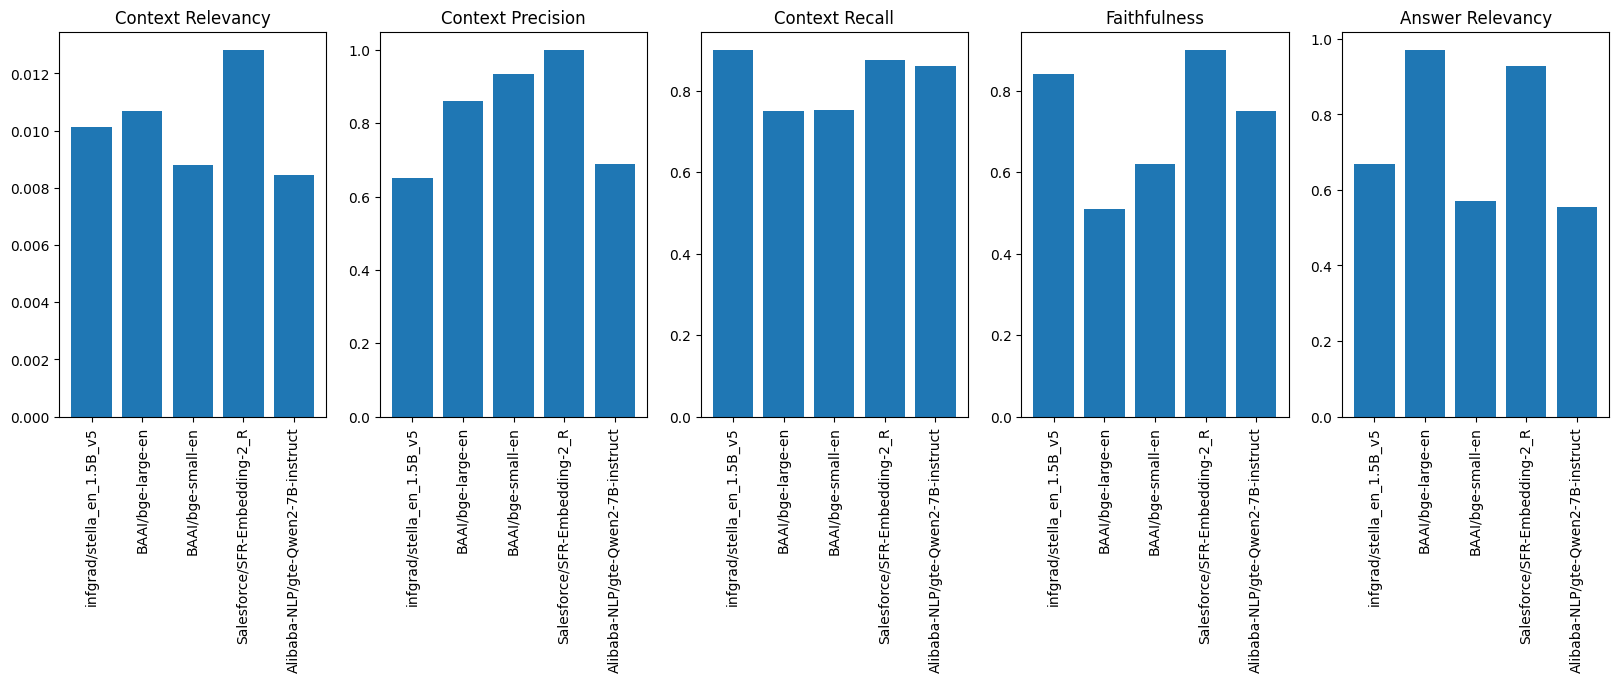

In [32]:
_, ax = plt.subplots(1, 5, figsize=(20, 5))

ax[0].bar(embedding_models, context_relevancy_result)
ax[0].set_title("Context Relevancy")
ax[0].set_xticklabels(embedding_models, rotation=90)

ax[1].bar(embedding_models, context_precision_result)
ax[1].set_title("Context Precision")
ax[1].set_xticklabels(embedding_models, rotation=90)

ax[2].bar(embedding_models, context_recall_result)
ax[2].set_title("Context Recall")
ax[2].set_xticklabels(embedding_models, rotation=90)

ax[3].bar(embedding_models, faithfulness_result)
ax[3].set_title("Faithfulness")
ax[3].set_xticklabels(embedding_models, rotation=90)

ax[4].bar(embedding_models, answer_relevancy_result)
ax[4].set_title("Answer Relevancy")
ax[4].set_xticklabels(embedding_models, rotation=90)

plt.show()